# 단어 문서 행렬(Term Document Matrix, TDM)
- 텍스트 데이터에서 문서와 단어 간의 관계를 수치화한 행렬
- 문서별로 단어의 빈도를 정리한 행렬
- 비정형 데이터인 텍스트를 행렬 형태로 정형화
- BOW(Bag of Words)
    - 문서가 가지는 모든 단어(Words)를 문맥이나 순서를 무시하고 일괄적으로 단어에 대해 빈도 값을 부여해 피처 값을 추출하는 방법


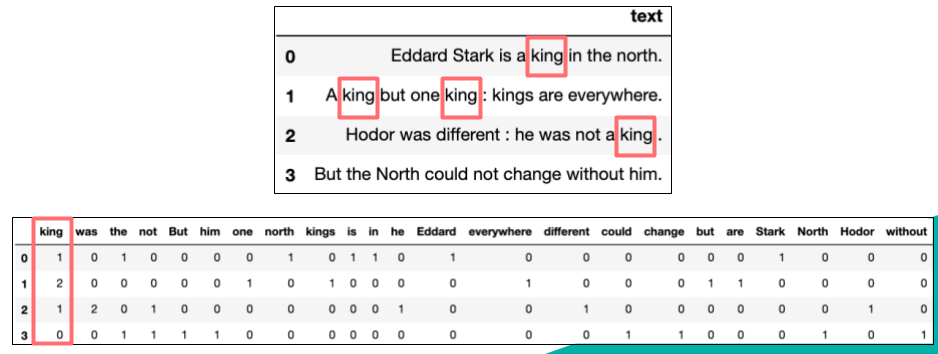

## 종류
- 단순 빈도 (TF, Term Frequency)
    - 각 셀 값은 해당 단어가 특정 문서에 등장한 횟수
- TF-IDF (Term Frequency-Inverse Document Frequency)
    - 단순 빈도를 보정하여, 문서 간 차별화되는 단어를 강조하는 가중치를 부여한 방식
- 이진(Binary) 행렬
    - 단어가 등장하면 1, 등장하지 않으면 0으로 표현

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# 영화리뷰 긍/부정 분류 데이터셋
- https://drive.google.com/file/d/1aMjRX-XWsR-uwNIFzbq9_uWfD2lmzXF-/view?usp=sharing

In [2]:
DATA_PATH = "../data/"
SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv(f"{DATA_PATH}imdb_dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df["sentiment"] = (df["sentiment"] == "positive").astype(int)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
target = df["sentiment"].to_numpy().reshape(-1, 1)
target.shape

(50000, 1)

In [6]:
target.mean()

0.5

# CounterVectorizer
- 문서를 단어의 단순 빈도로 벡터화
- 주요 파라미터
    - lowercase: 소문자로 변환(기본값: True)
    - tokenizer: 토큰화 방식을 콜백함수로 전달
    - token_pattern: 정규식을 이용하여 토큰화
    - stop_words: 불용어 제거(기본값: None)
    - max_df: 자주 등장하는 단어 제외(실수: 문서 비율, 정수: 문서 수)
        - 기본값: 1.0
    - min_df: 거의 등장하지 않는 단어 제외(실수: 문서 비율, 정수: 문서 수)
        - 기본값: 1
    - max_features: 전체에서 빈도수 기준으로 최대 몇 개의 단어를 구축할 지에 대한 개수
        - 기본값: None
    - ngram_range: 토큰 묶음 단위에 대한 n-gram 범위
        - 기본값: (1, 1)

## N-gram
- N 개의 연속된 토큰 묶음을 의미
- N = 1: Unigram, 토큰 1개
- N = 2: Bigram, 연속된 토큰 2개 묶음
- N = 3: Trigram, 연속된 토큰 3개 묶음

In [50]:
# 토크나이저 전달 예시
# def cb_func(text):
#     return text.split("_")

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(["br", "10"])

In [8]:
cnt_vec = CountVectorizer(max_features=100, stop_words=stop_words)
tf_tdm = cnt_vec.fit_transform(df["review"]).toarray()
tf_tdm.shape

(50000, 100)

In [9]:
tf_tdm = pd.DataFrame(tf_tdm, columns=cnt_vec.get_feature_names_out())
tf_tdm.head()

,acting,action,actors,actually,away,bad,best,better,big,bit,...,want,watch,watching,way,woman,work,world,worst,years,young
0,0,0,0,0,2,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,1,1,0,0,0


In [10]:
tf_tdm.sum()

acting      12867
action       6497
actors       8951
actually     8470
away         5509
            ...  
work         8546
world        7496
worst        5334
years        8759
young        7045
Length: 100, dtype: int64

In [11]:
from wordcloud import WordCloud

wc = WordCloud(width=500, height=500, random_state=SEED, background_color="white")

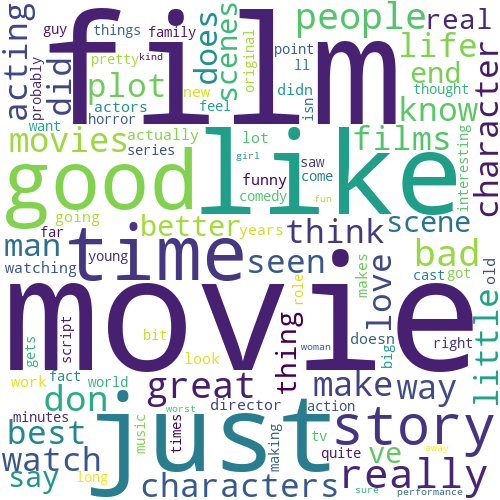

In [12]:
wc_obj = wc.generate_from_frequencies(tf_tdm.sum())
wc_obj.to_image()

# TF-IDF
- 단어 빈도(TF)에 역문서 빈도(IDF)를 곱한 값
- 단어 빈도에 가중치를 주는 방법
- DF: 문서 빈도
    - 각 단어가 등장한 문서의 수
- IDF: 역문서 빈도
    - 총 문서 수를 DF로 나눈 값

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(max_features=100, stop_words=stop_words)
tfidf_tdm = tfidf_vec.fit_transform(df["review"]).toarray()
tfidf_tdm.shape

(50000, 100)

In [14]:
tfidf_tdm = pd.DataFrame(tfidf_tdm, columns=tfidf_vec.get_feature_names_out())
tfidf_tdm.head()

,acting,action,actors,actually,away,bad,best,better,big,bit,...,want,watch,watching,way,woman,work,world,worst,years,young
0,0.000000,0.000000,0.000000,0.0,0.362587,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.312702,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.272614,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.268270,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.199503,0.168985,0.24411,0.000000,0.000000,0.0,0.204344,0.224635
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.150056,0.200933,0.000000,0.0,0.000000,0.0,0.156014,0.0,0.187944,0.0,...,0.0,0.148908,0.000000,0.144133,0.00000,0.176151,0.188154,0.0,0.000000,0.000000


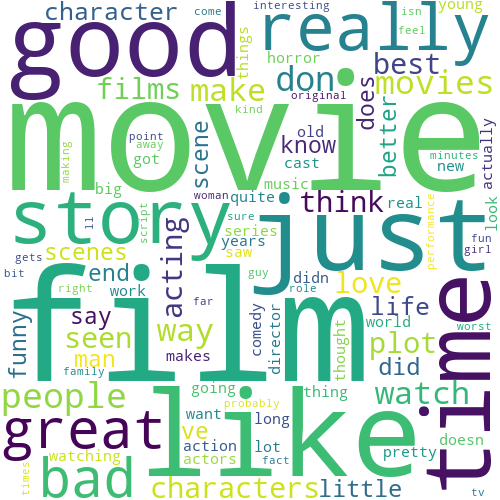

In [15]:
wc_obj = wc.generate_from_frequencies(tfidf_tdm.sum())
wc_obj.to_image()

In [16]:
tf_tdm.shape, tfidf_tdm.shape

((50000, 100), (50000, 100))

# 유사도

## 자카드 유사도
- 교집합의 크기 / 합집합의 크기

In [17]:
def get_jaccard(text1, text2):
    text1 = set(text1.split())
    text2 = set(text2.split())
    intersection = len(text1.intersection(text2))
    union = len(text1.union(text2))

    return intersection / union

In [18]:
get_jaccard(df["review"][0], df["review"][1])

0.08783783783783784

## 코사인 유사도
- 문서의 유사도를 계산할 때 사용
- -1 ~ 1 사이의 값을 가지고, 1에 가까울수록 유사도가 높다고 해석
$${\displaystyle {\text{similarity}}=\cos(\theta )={A\cdot B \over \|A\|\|B\|}={\frac {\sum \limits _{i=1}^{n}{A_{i}\times B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{(A_{i})^{2}}}}\times {\sqrt {\sum \limits _{i=1}^{n}{(B_{i})^{2}}}}}}}$$

- 활용 사례
    - 문서 검색 시스템
        - 사용자가 입력한 검색어와 유사한 문서를 추천
    - 텍스트 분류
        - 스팸 메일끼리의 유사도를 구해 스팸 분류

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

In [64]:
cosine_similarity(tf_tdm.iloc[:1], tf_tdm.iloc[1:2])

array([[0.16979054]])

In [65]:
cosine_similarity(tf_tdm.iloc[:5])

array([[1.        , 0.16979054, 0.20567735, 0.13151919, 0.02450715],
       [0.16979054, 1.        , 0.26919095, 0.20655911, 0.07698004],
       [0.20567735, 0.26919095, 1.        , 0.04170288, 0.21758446],
       [0.13151919, 0.20655911, 0.04170288, 1.        , 0.2981424 ],
       [0.02450715, 0.07698004, 0.21758446, 0.2981424 , 1.        ]])

In [66]:
tf_tdm.shape, tfidf_tdm.shape, target.shape

((50000, 100), (50000, 100), (50000, 1))

In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tf_tdm = scaler.fit_transform(tf_tdm)
tf_tdm

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09090909, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14285714,
        0.1       ],
       ...,
       [0.125     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.1       , 0.        ,
        0.        ]])

In [68]:
tfidf_tdm = tfidf_tdm.to_numpy()
tfidf_tdm

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27261424, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.20434356,
        0.22463457],
       ...,
       [0.20096243, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.19853769, 0.        ,
        0.        ]])

# ML 학습

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(5, shuffle=True, random_state=SEED)

- TF-TDM 데이터 CV 점수 확인

In [71]:
model = LogisticRegression(random_state=SEED)
scores = cross_val_score(model, tf_tdm, target, scoring="accuracy", cv=cv, n_jobs=-1)
np.mean(scores)

0.7421599999999999

- TFIDF-TDM 데이터 CV 점수 확인

In [72]:
model = LogisticRegression(random_state=SEED)
scores = cross_val_score(model, tfidf_tdm, target, scoring="accuracy", cv=cv, n_jobs=-1)
np.mean(scores)

0.7437600000000001

- 병합 데이터 CV 점수 확인

In [78]:
concatenated_data = np.concatenate([tf_tdm, tfidf_tdm], axis=1)
concatenated_data.shape

(50000, 200)

In [79]:
model = LogisticRegression(random_state=SEED)
scores = cross_val_score(model, concatenated_data, target, scoring="accuracy", cv=cv, n_jobs=-1)
np.mean(scores)

0.7449000000000001

In [80]:
from sklearn.feature_selection import SelectKBest

skb = SelectKBest(k=50)
skb_tf_tdm = skb.fit_transform(tf_tdm, target)
scores = cross_val_score(model, np.concatenate([tf_tdm, tfidf_tdm], axis=1), target, scoring="accuracy", cv=cv, n_jobs=-1)
np.mean(scores)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7449000000000001

In [81]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
pca_train = pca.fit_transform(concatenated_data)
scores = cross_val_score(model, pca_train, target, scoring="accuracy", cv=cv, n_jobs=-1)
np.mean(scores)

0.7409800000000001

In [82]:
from sklearn.feature_selection import RFECV

estimator = LogisticRegression(random_state=SEED)
rfecv = RFECV(estimator, cv=cv, scoring="accuracy", n_jobs=-1)
rfecv_train = rfecv.fit_transform(concatenated_data, target)
scores = cross_val_score(model, pca_train, target, scoring="accuracy", cv=cv, n_jobs=-1)
np.mean(scores)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.7409800000000001

# 데이터셋 클래스

In [83]:
class MovieReviewDataset(torch.utils.data.Dataset):
    def __init__(self, x, y=None):
        self.x, self.y = x, y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        item = {}
        item["x"] = torch.Tensor(self.x[i])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[i])

        return item

In [84]:
dataset = MovieReviewDataset(concatenated_data, target)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2)
batch = next(iter(dataloader))
batch

{'x': tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1250, 0.0000, 0.0000, 0.1429, 0.0000, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0769, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.1333, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.2222,
          0.0000, 0.1250, 0.2222, 0.0000, 0.0909, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3626, 0.0000, 0.0000, 0.0000,
          0

# 모델 클래스

In [85]:
class Net(torch.nn.Module):
    def __init__(self, in_features, hidden_size):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(in_features, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_size, hidden_size // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 2, hidden_size // 4),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size // 4, 1)
        )

    def forward(self, x):
        return self.seq(x)

In [86]:
model = Net(concatenated_data.shape[1], 32)
model(batch["x"])

tensor([[0.3040],
        [0.2964]], grad_fn=<AddmmBackward0>)

# 학습 루프

In [87]:
def train_loop(dataloader, model, loss_function, optimizer, device):
    epoch_loss = 0
    model.train()

    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_function(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    return epoch_loss

# 테스트 루프

In [88]:
@torch.no_grad()
def test_loop(dataloader, model, loss_function, device):
    epoch_loss = 0
    model.eval()

    act = torch.nn.Sigmoid()
    pred_list = []
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        if batch.get("y") is not None:
            loss = loss_function(pred, batch["y"].to(device))
            epoch_loss += loss.item()

        pred = act(pred)
        pred = pred.to("cpu").numpy()
        pred_list.append(pred)

    pred = np.concatenate(pred_list)
    epoch_loss /= len(dataloader)

    return epoch_loss, pred

# 학습

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
batch_size = 32
loss_function = torch.nn.BCEWithLogitsLoss()
epochs = 100
in_features = concatenated_data.shape[1]
hidden_size = 16
n_splits = 5 # KFold의 K값

In [ ]:
is_holdout = True
reset_seeds(SEED)
score_list = []

for i, (tri, vai) in enumerate(cv.split(concatenated_data)):
    x_train = concatenated_data[tri]
    y_train = target[tri]
    train_dataset = MovieReviewDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    x_valid = concatenated_data[vai]
    y_valid = target[vai]
    valid_dataset = MovieReviewDataset(x_valid, y_valid)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    model = Net(in_features, hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    patience = 0
    best_score = 0
    for _ in range(epochs):
        train_loss = train_loop(train_dataloader, model, loss_function, optimizer, device)
        valid_loss, pred = test_loop(valid_dataloader, model, loss_function, device)
        pred = (pred > 0.5).astype(int)
        score = accuracy_score(y_valid, pred)
        patience += 1

        if score > best_score:
            best_score = score
            patience = 0
            torch.save(model.state_dict(), f"../output/model{i}.pt")

        if patience == 5:
            break

    score_list.append(best_score)
    print(f"ACC 최고점수: {best_score}")

    if is_holdout:
        break

ACC 최고점수: 0.7456
